In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'adbe' # ticker symbol
train = 0 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1, 3, or 5 days ahead
days_back = -1 # -1 for current data point, -2 for two days ago, etc...
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'a': '11/15/1999'# Updated 1/5/21 1D, 3D, 5D ahead
               , 'aapl':'12/12/1980' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'acy': '01/18/1998' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'adbe': '08/11/1986' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'amd': '03/17/1980' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'baba': '09/15/2014' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'bac': '02/19/1973' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'crm': '06/23/2004' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'goog': '08/16/2004' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'idex': '05/23/2007' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'intc': '03/16/1980' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'ma': '05/21/2006' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'msft': '03/10/1986' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'nio': '09/10/2018' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'nvda': '01/22/1999' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'pypl': '07/05/2015' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'tsla': '06/29/2010' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'v': '03/16/2008' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'vbiv': '09/04/2002' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'vbr': '01/26/2004' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'viov': '09/06/2010' # Updated 1/5/21 1D, 3D, 5D ahead
               , 'vgt': '01/26/2004' # Updated 1/5/21 1D, 3D, 5D ahead
              }

In [4]:
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-21,502.000000,491.500000,498.049988,498.390015,2412900.0,498.390015,-0.000683,0.021363,-0.009067,0.012310,0.004934,1
2020-12-22,506.920013,495.829987,498.359985,504.170013,1701500.0,504.170013,-0.011658,0.022367,0.011597,0.010174,0.008808,-1
2020-12-23,505.459991,496.589996,505.130005,496.910004,1428300.0,496.910004,0.016273,0.017862,-0.014400,0.013605,0.002920,1
2020-12-24,503.010010,497.279999,499.160004,499.859985,589200.0,499.859985,-0.001402,0.011523,0.005937,0.013004,0.001878,-1
2020-12-28,506.040009,496.820007,505.609985,498.950012,1515400.0,498.950012,0.013172,0.018558,-0.001820,0.010614,-0.001551,1
2020-12-29,505.350006,499.739990,501.170013,502.109985,1434100.0,502.109985,-0.001876,0.011226,0.006333,0.010110,0.001529,-1
2020-12-30,504.369995,496.329987,503.049988,497.450012,1529900.0,497.450012,0.011132,0.016199,-0.009281,0.009181,-0.002646,1
2020-12-31,500.660004,494.890015,497.989990,500.119995,1462100.0,500.119995,-0.004277,0.011659,0.005367,0.006802,0.001307,-1
2021-01-04,500.790009,476.279999,500.299988,485.339996,3612500.0,485.339996,0.029902,0.051461,-0.029553,0.014698,-0.005791,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

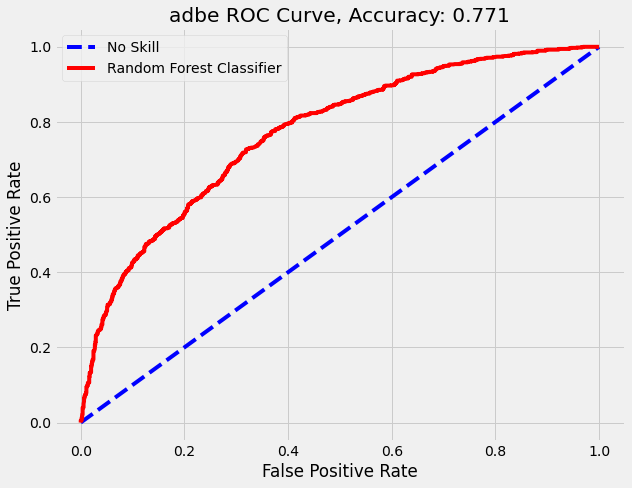

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

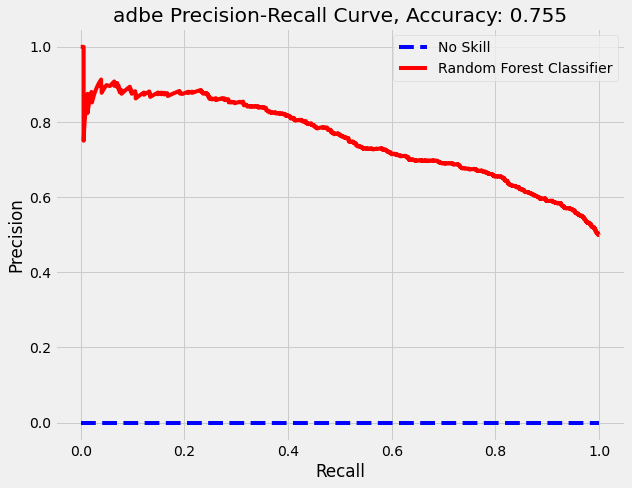

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

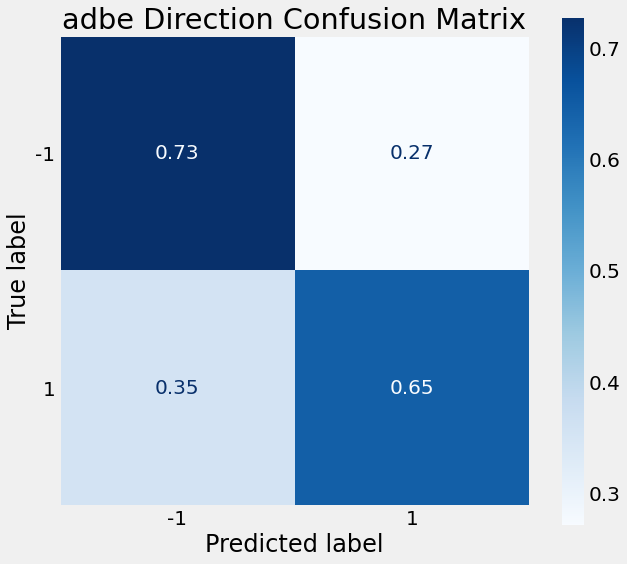

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.7135603000577034'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          4.860600e+02
Low           4.791950e+02
Open          4.858800e+02
Close         4.856900e+02
Volume        1.891791e+06
Adj Close     4.856900e+02
oc            3.910481e-04
hl            1.432609e-02
adj           7.211565e-04
5stdev_adj    1.491163e-02
5sma_adj     -5.282389e-03
direction    -1.000000e+00
Name: 2021-01-05 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-days_back]
last

oc            0.000000
hl            0.052632
5stdev_adj    0.028495
5sma_adj      0.000325
Name: 1986-08-21 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    8665.000000
mean        0.001417
std         0.031236
min        -0.301980
25%        -0.013341
50%         0.000000
75%         0.014706
max         0.322034
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name} {days_ahead} day(s) ahead')
else:
    print(f'Sell or hold {stock_name} {days_ahead} day(s) ahead')

Sell or hold adbe 1 day(s) ahead


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-29,505.350006,499.739990,501.170013,502.109985,1434100.0,502.109985,-0.001876,0.011226,0.006333,0.010110,0.001529,-1,-1,0.009281
2020-12-30,504.369995,496.329987,503.049988,497.450012,1529900.0,497.450012,0.011132,0.016199,-0.009281,0.009181,-0.002646,1,1,0.005367
2020-12-31,500.660004,494.890015,497.989990,500.119995,1462100.0,500.119995,-0.004277,0.011659,0.005367,0.006802,0.001307,-1,-1,0.029553
2021-01-04,500.790009,476.279999,500.299988,485.339996,3612500.0,485.339996,0.029902,0.051461,-0.029553,0.014698,-0.005791,1,1,0.000721
2021-01-05,486.059998,479.195007,485.880005,485.690002,1891791.0,485.690002,0.000391,0.014326,0.000721,0.014912,-0.005282,-1,1,0.000000


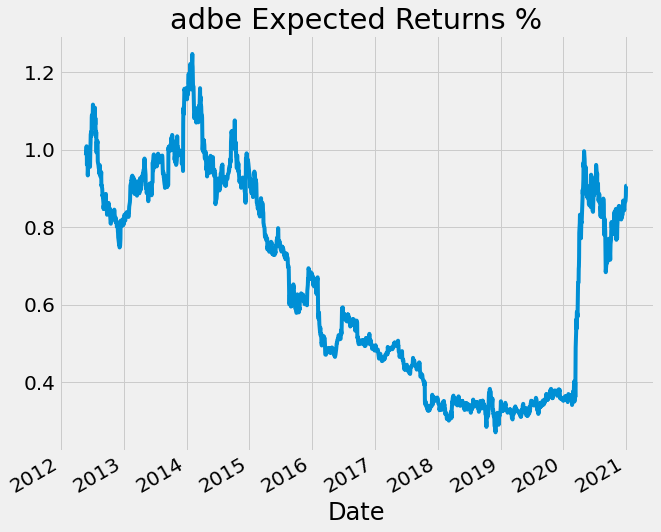

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

4.4689878996018475

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

102.9604018603679

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/

### Training

In [22]:
# this takes a while, 10.5+ hours!
# stocks = [x for x in start_dates]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

### Recording Results